In [160]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import IntegerComparator, GroverOperator
from collections.abc import Callable
import numpy as np 
from tqdm import tqdm

In [2]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [95]:
def comparator_oracle(n, value):
    qc = QuantumCircuit(n * 2 + 1)
    ic = IntegerComparator(num_state_qubits=n, geq=False, value=value)
    ici = ic.inverse()
    qc.append(ic, qc.qubits[:-1])
    qc.cx(n, n*2)
    qc.append(ici, qc.qubits[:-1])
    qc.name = f"cmp_{value}"
    return qc

In [4]:
# https://qiskit.org/textbook/ch-algorithms/grover.html#sudoku
def grover(n, value):
    iter = int(np.sqrt(n))
    n = int(np.ceil(np.log2(n)))

    qc = QuantumCircuit(n * 2 + 1, n)
    qc.x(n * 2)
    qc.h(list(range(n)) + [n * 2])

    qc.barrier()

    for i in range(iter):
        qc.append(comparator_oracle(n, value))
        qc.append(diffuser(n), qc.qubits[0:n])

        qc.barrier()

    qc.measure(qc.qubits[0:n], qc.clbits[:])
    sim = Aer.get_backend('qasm_simulator')
    counts = execute(qc, backend=sim).result().get_counts()
    return int(list(counts.keys())[0], 2)

In [185]:
def groverQram(arr_len, value):
    m = int(np.ceil(np.log2(arr_len)))
    n = 4
    iter = int(np.sqrt(arr_len))

    clen = m + n * 2 + 1
    qc = QuantumCircuit(clen, m)
    qc.x(clen - 1)
    qc.h(list(range(m)) + [clen - 1])

    qram = QramCircuit(nums, 4)

    ic = IntegerComparator(num_state_qubits=n, geq=False, value=value)
    ici = ic.inverse()

    qc.name = f"cmp_{value}"

    qc.append(qram, qc.qubits[0:m+n])

    for i in range(iter):
        qc.append(ic, qc.qubits[m: clen - 1])
        qc.cx(m + n, clen - 1)
        qc.append(ici, qc.qubits[m: clen - 1])

    qc.append(qram, qc.qubits[0:m+n])

    qc.append(diffuser(m), qc.qubits[0:m])

    qc.measure(qc.qubits[0:m], qc.clbits[:])
    
    sim = Aer.get_backend('qasm_simulator')
    counts = execute(qc, backend=sim).result().get_counts()
    return int(list(counts.keys())[0], 2)

In [164]:
def durrHoyer(nums, iter = None):
    n = len(nums)
    thres = np.random.randint(n)
    if iter is None:
        iter = int(22.5 * np.sqrt(n) + 1.4 * np.log(n) ** 2)
    gmin = thres
    print('running iter:', iter)
    for i in range(iter):
        nmin = grover(n, thres)
        if nmin < gmin:
            gmin = nmin
            thres = gmin
    return gmin

In [177]:
def durrHoyerQram(nums, iter = None):
    n = len(nums)
    thresi = np.random.randint(n)
    thres = nums[thresi]
    if iter is None:
        iter = int(22.5 * np.sqrt(n) + 1.4 * np.log(n) ** 2)
    gmin = thres
    print('running iter:', iter)
    for i in tqdm(range(iter)):
        argmin = groverQram(n, thres)
        if argmin >= n:
            continue
        nmin = nums[argmin]
        if nmin < gmin:
            gmin = nmin
            thres = gmin
    return gmin

In [187]:
nums = [4, 5, 10]
durrHoyerQram(nums)

running iter: 40


100%|██████████| 40/40 [00:10<00:00,  3.93it/s]


4

{'0111': 106, '1000': 92, '0010': 7, '1011': 81, '1100': 90, '0110': 86, '1101': 88, '1110': 86, '1111': 115, '1010': 88, '0101': 80, '1001': 82, '0011': 5, '0001': 5, '0100': 6, '0000': 7}


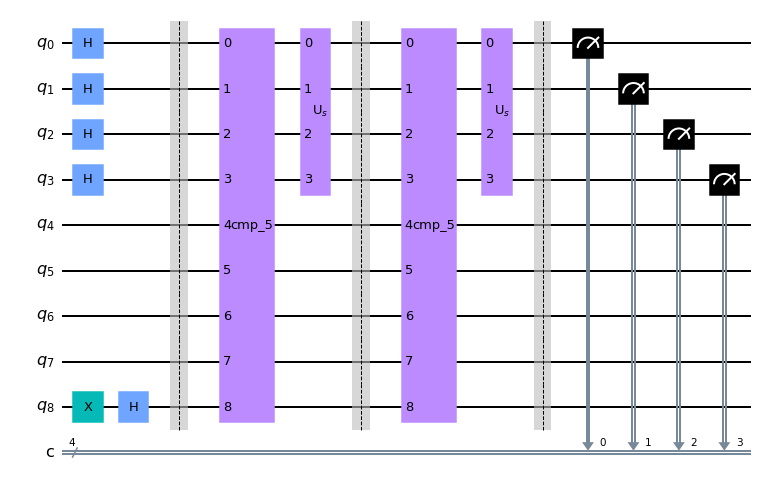

In [96]:

n = 4
value = 5
iter = int(np.floor(np.sqrt(n)))

qc = QuantumCircuit(n * 2 + 1, n)
qc.x(n * 2)
qc.h(list(range(n)) + [n * 2])

qc.barrier()

for i in range(iter):
    qc.append(comparator_oracle(n, value), qc.qubits[0: n*2+1])
    qc.append(diffuser(4), qc.qubits[0:n])

    qc.barrier()

qc.measure(qc.qubits[0:n], qc.clbits[:])
sim = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=sim, shots=1024).result().get_counts()
print(counts)
qc.draw('mpl')

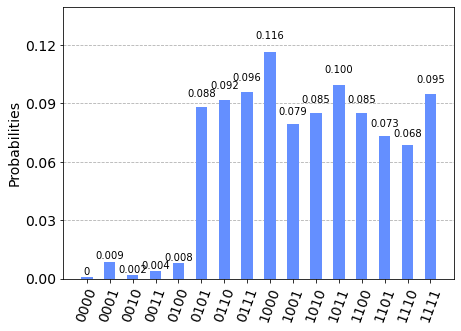

In [156]:
plot_histogram(counts)

In [138]:

def QramCircuit(nums, s_mem = 4):
    size = len(nums)
    s_addr = int(np.ceil(np.log2(size)))

    qc = QuantumCircuit(s_addr + s_mem)

    lastflips = [0, 0, 0, 0]

    for i in range(size):
        val = nums[i]
        
        # change all 0 bits to 1

        # if j's bit is 0, flip it to 1
        t_addr = i
        for j in range(s_addr):
            flip = (t_addr & 1) == 0
            # print(i, t_addr, flip)
            flip ^= lastflips[j]
            if flip:
                qc.x(j)
            t_addr >>= 1
        
        # apply toffoli gates to map address to memory
        t_val = val
        for j in range(s_mem):
            one = (t_val & 1)
            if one:
                qc.mct(list(range(s_addr)), s_addr + j)
            t_val >>= 1
        
        # flip back
        t_addr = i
        for j in range(s_addr):
            flip = (t_addr & 1) == 0
            lastflips[j] = flip
            # if flip:
            #     qc.x(j)
            t_addr >>= 1

        qc.barrier()

    qc.name = 'qram'

    return qc

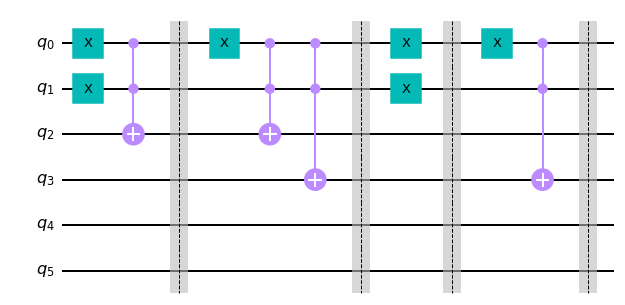

In [135]:
nums = [1, 3, 0, 2]
QramCircuit(nums, 4).draw('mpl')

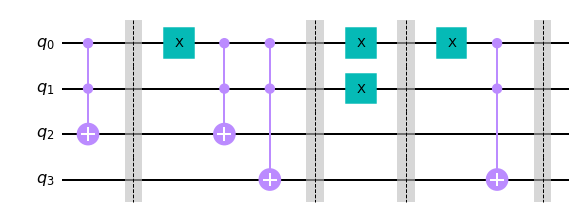

In [116]:
QramCircuit(nums, 2, True).draw('mpl')

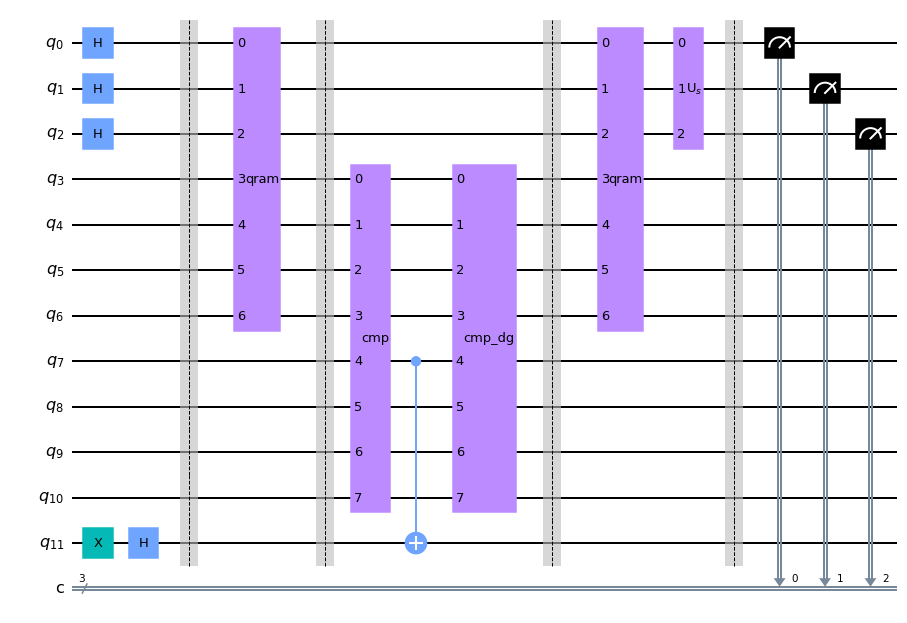

In [154]:
# qc = QuantumCircuit(3, 2)
# qc.h(0)
# # qc.h(1)
# qc.append(QramCircuit(nums, 2), qc.qubits)

nums = [11, 15, 10, 7, 9, 1, 0]

n = 4
m = int(np.ceil(np.log2(len(nums))))
value = 2
iter = int(np.floor(np.sqrt(m)))
# iter = 1

clen = m + n * 2 + 1
qc = QuantumCircuit(clen, m)
qc.x(clen - 1)
qc.h(list(range(m)) + [clen - 1])
qc.barrier()

qram = QramCircuit(nums, 4)

ic = IntegerComparator(num_state_qubits=n, geq=False, value=value)
ici = ic.inverse()

qc.name = f"cmp_{value}"

qc.append(qram, qc.qubits[0:m+n])

qc.barrier()

for i in range(iter):
    # qc.append(comparator_oracle(n, value), qc.qubits[m : m + n * 2 + 1])
    qc.append(ic, qc.qubits[m: clen - 1])
    qc.cx(m + n, clen - 1)
    qc.append(ici, qc.qubits[m: clen - 1])

    qc.barrier()

qc.append(qram, qc.qubits[0:m+n])

qc.append(diffuser(m), qc.qubits[0:m])

qc.barrier()

qc.measure(qc.qubits[0:m], qc.clbits[:])
qc.draw('mpl')


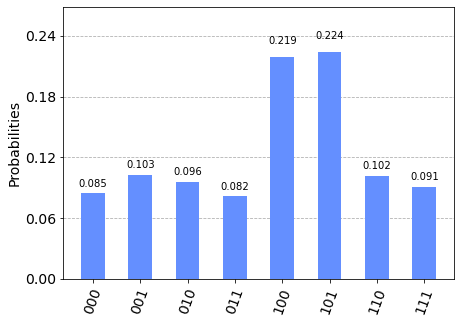

In [157]:
sim = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=sim, shots=1024).result().get_counts()
plot_histogram(counts)